# Heart Disease Prediction 2 (UCI)

Dataset originally from: https://archive.ics.uci.edu/ml/datasets/Heart+Disease




- Age : Age of the patient
- Sex : Sex of the patient
- exang: exercise induced angina (1 = yes; 0 = no)
- caa: number of major vessels (0-3)
- cp : Chest Pain type chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- rest_ecg : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalachh : maximum heart rate achieved
- oldpeak: ST depression induced by exercise relative to rest. ST depression refers to a finding on an electrocardiogram, wherein the trace in the ST segment is abnormally low below the baseline. 
- slp : 
- thall : 
- output (TARGET) : 
    - 0: no heart disease 
    - 1: some level of heart disease

In [1]:
#Load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from bs4 import BeautifulSoup
import time
import requests     # to get images
import shutil       # to save files locally
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
import os
from matplotlib.pyplot import figure
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.linear_model import SGDClassifier
import xgboost


In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
# Pick a font
plt.rcParams.update({'font.family':'Bell MT'})

In [5]:
#Identify columns with missing values
nothere = df.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]
nothere

,0


There are no missing values. 

In [6]:
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [7]:
df.describe().round(2)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,54.37,0.68,0.97,131.62,246.26,0.15,0.53,149.65,0.33,1.04,1.40,0.73,2.31,0.54
std,9.08,0.47,1.03,17.54,51.83,0.36,0.53,22.91,0.47,1.16,0.62,1.02,0.61,0.50
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,47.50,0.00,0.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00,2.00,0.00
50%,55.00,1.00,1.00,130.00,240.00,0.00,1.00,153.00,0.00,0.80,1.00,0.00,2.00,1.00
75%,61.00,1.00,2.00,140.00,274.50,0.00,1.00,166.00,1.00,1.60,2.00,1.00,3.00,1.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,2.00,4.00,3.00,1.00


### Rename the columns for more transparency 

In [8]:
df = df.rename(columns= {'cp': 'chest_pain_type', 'trtbps' : 'resting_blood_pressure', 
                        'chol': 'cholestoral', 'fbs' : 'fasting_blood_sugar_>120mg_dl',
                        'restecg' : 'resting_ecg_results', 'thalachh': 'max_heart_rate',
                        'exng': 'exercise_induced_anigina', 'oldpeak': 'previous_peak',
                        'caa' : 'number_major_vessels_0-3', 'thall' : 'thall_rate',
                         'slp' : 'slope'})

### Check the Distributions

In [9]:
num = len(df.columns)
num2 = round(num/2, 0)

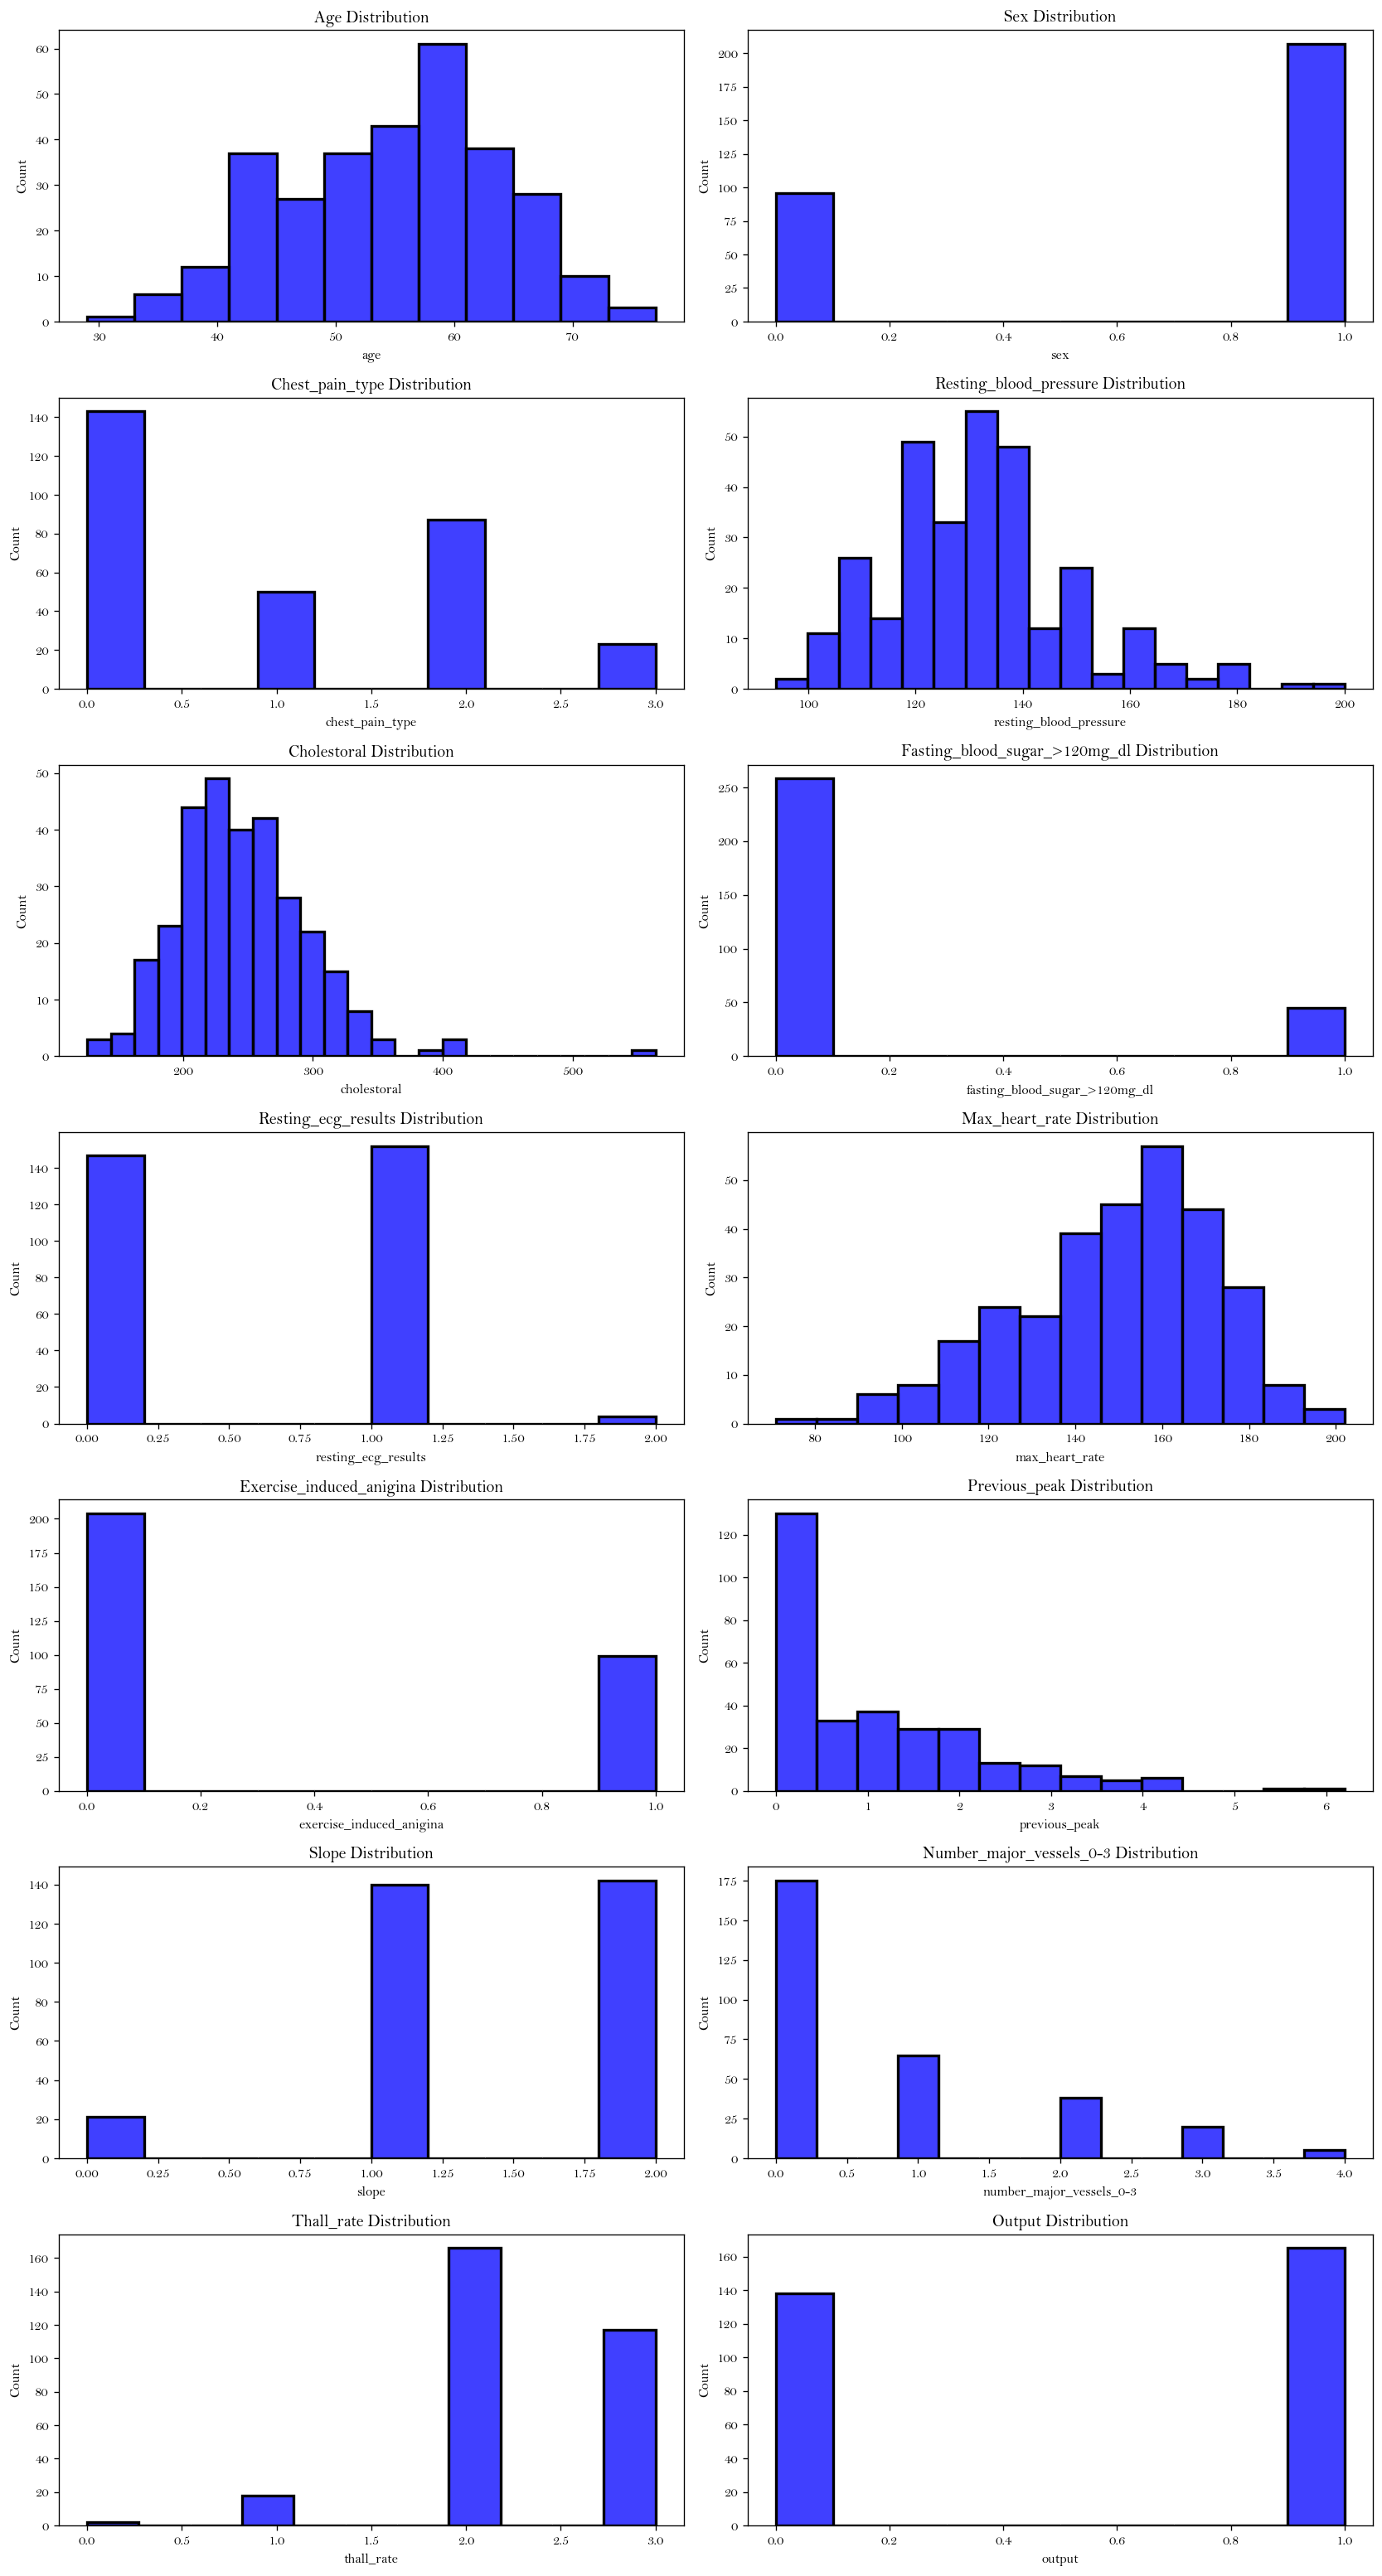

In [10]:
plt.figure(figsize = (14,26), dpi = 120)

for n, column in enumerate(df.columns, 1):
    plt.subplot(int(num2),2,n)
    sns.histplot(df[column], color='b', edgecolor="black", linewidth=2)
    plt.tight_layout()
    col = str.capitalize(column)
    plt.title(f'{col} Distribution')
    plt.plot()

From these plots, we see that we have five continuous data columns:
- Age
- Trtbips (resting blood pressure)
- Chol (cholestorol)
- thalachh (maximum heart rate achieved)
- Previous Peak ()

In [11]:
cont_vars_n_target = ['age', 'max_heart_rate', 'cholestoral', 'resting_blood_pressure', 'previous_peak']

Let's check out their distributions, compared to a normal distribution. 

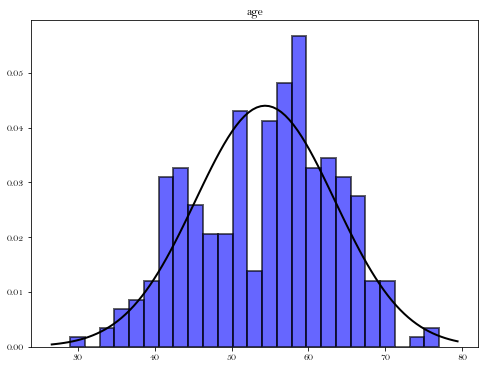

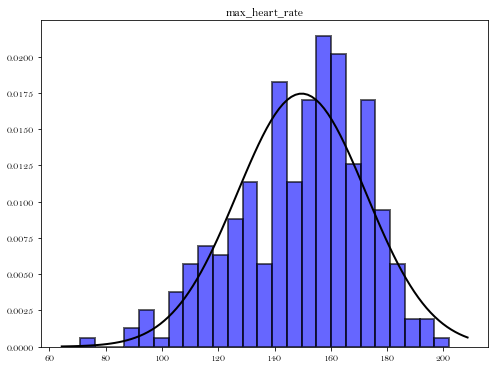

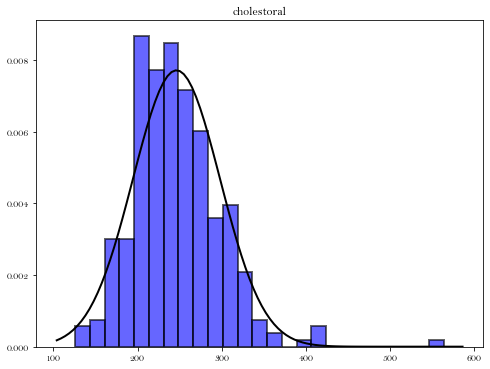

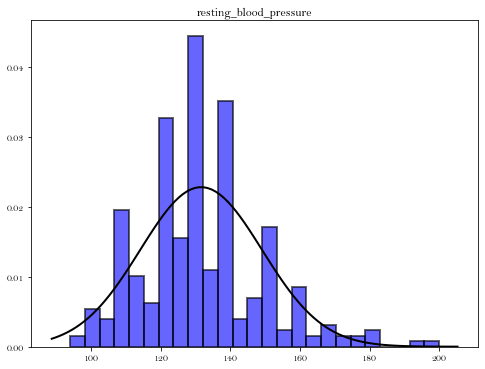

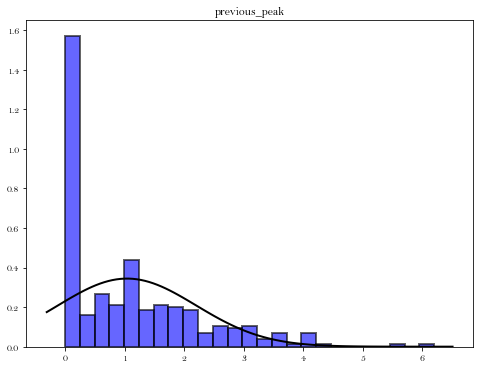

In [12]:
df1 = df[cont_vars_n_target]

for column in df1:
    data = df1[column]
    mu, std = norm.fit(data) 
    figure(figsize= (8,6))
    plt.hist(df1[column], bins=25, density=True, alpha=0.6, color='b', edgecolor="black", linewidth=2)
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std) 
    plt.plot(x, p, 'k', linewidth=2)
    title = str(column)
    plt.title(title) 
    plt.show()

## 2. EDA

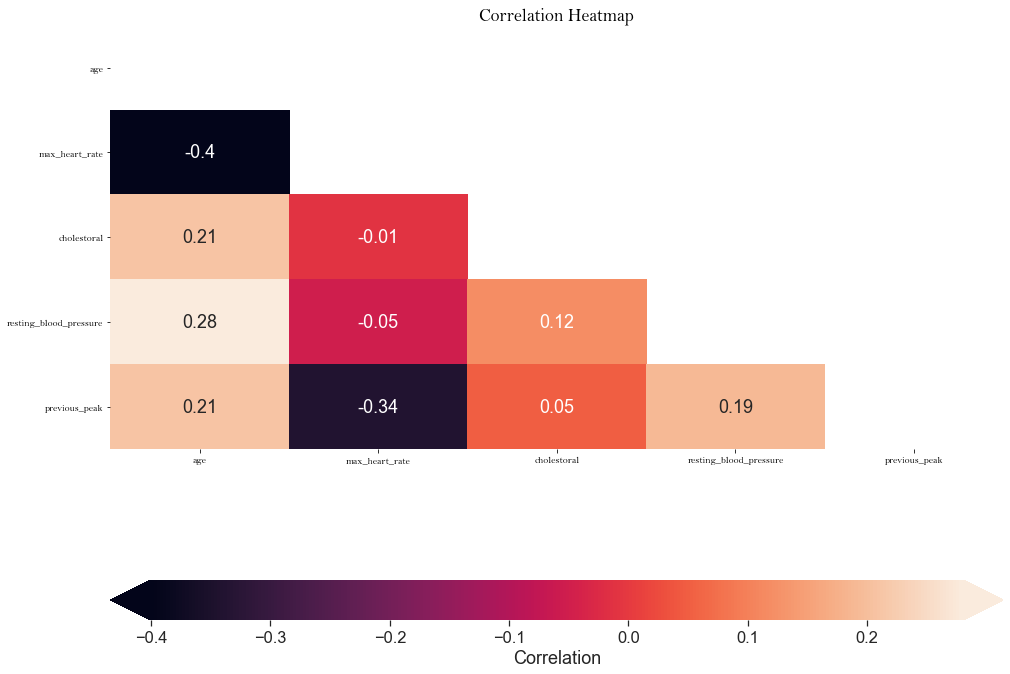

In [13]:
# Create a df with the target as the first column,
# then compute the correlation matrix
corr = df[cont_vars_n_target].corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(16, 12))
sns.set(font_scale = 1.5)

# Plot
sns.heatmap(
    data=corr.round(2),
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize appearance
ax.set_title("Correlation Heatmap");

In [14]:
df_cat = df.drop(columns= ['resting_blood_pressure', 'cholestoral', 'max_heart_rate', 'age', 'previous_peak'])

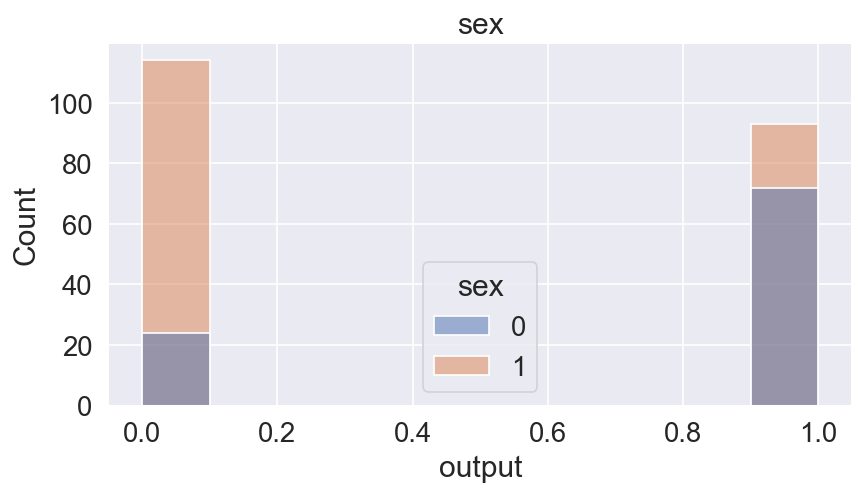

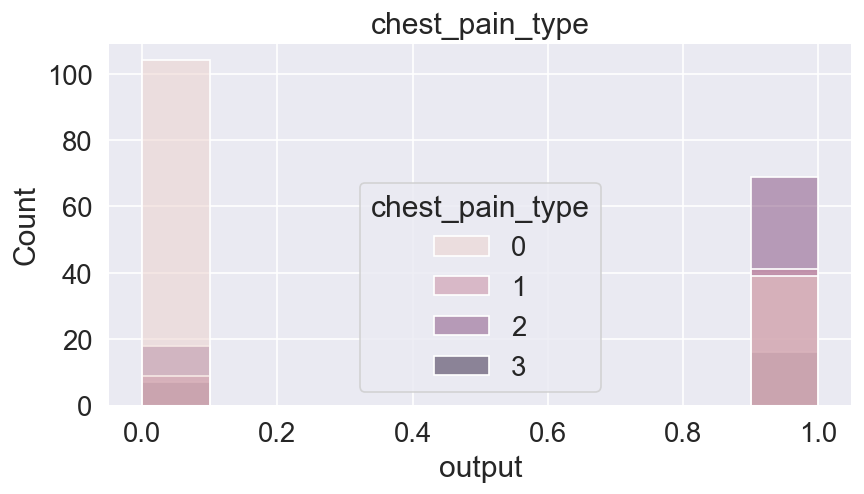

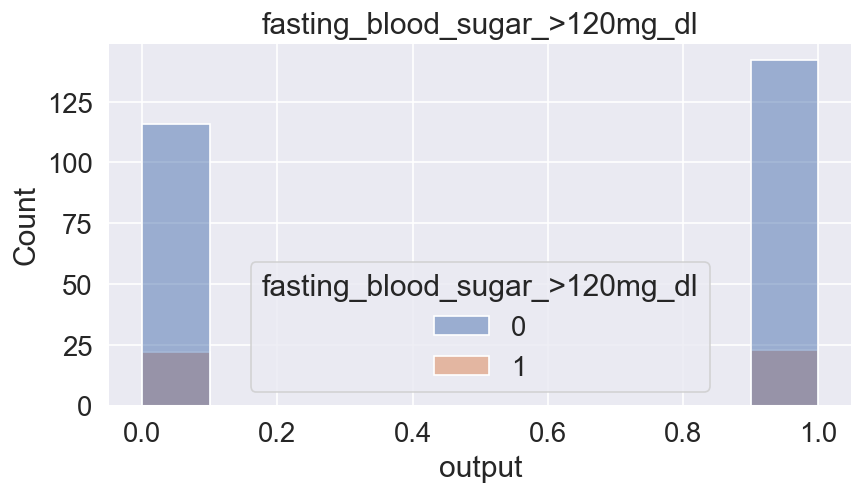

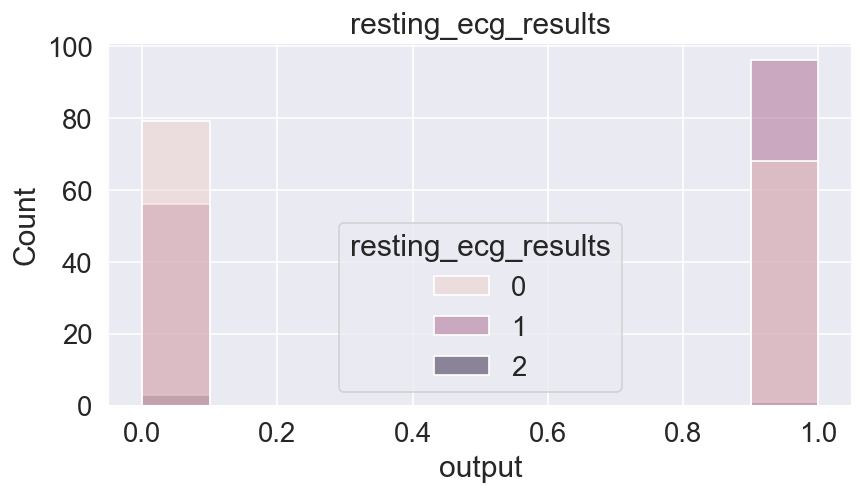

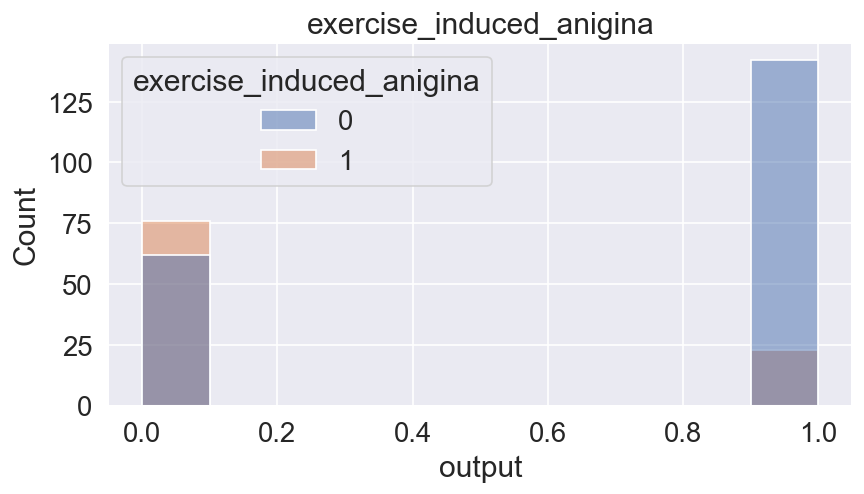

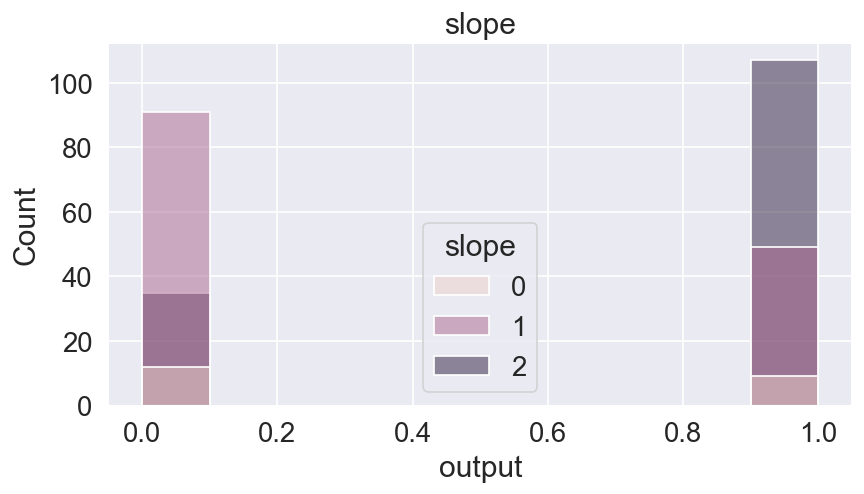

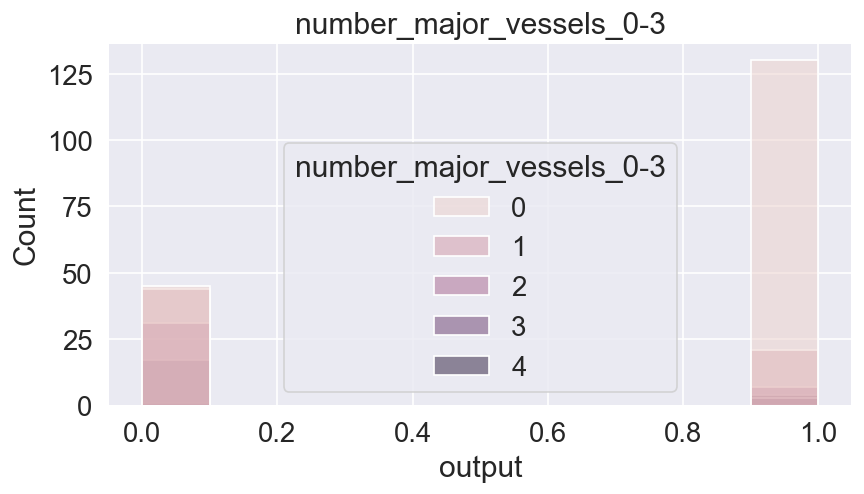

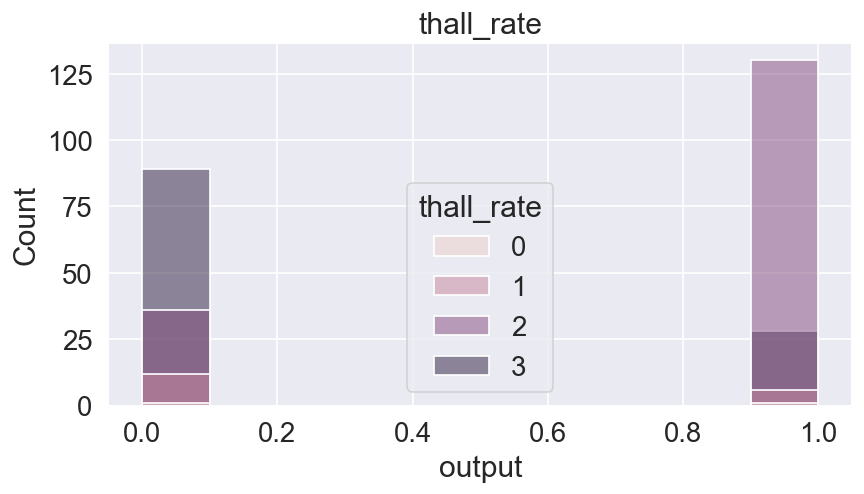

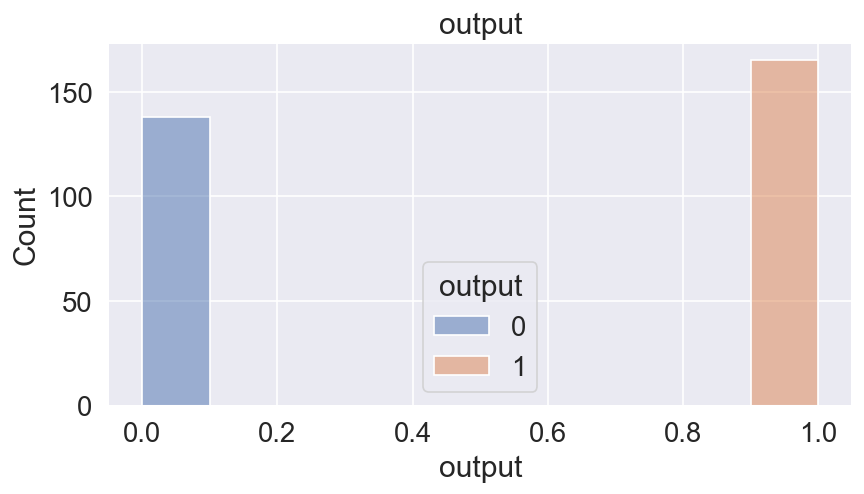

In [15]:
for column in df_cat:
    figure(figsize = (8,4), dpi = 120)
    sns.histplot(data=df_cat, x='output', hue=column)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    title = str(column)
    plt.title(title) 
    plt.show()

## EDA Findings

## Target Variable

In [16]:
X = df.drop(['output'],axis=1)
y = df[['output']]

## Encoding and Normalizing

In [17]:
df.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'cholestoral', 'fasting_blood_sugar_>120mg_dl', 'resting_ecg_results',
       'max_heart_rate', 'exercise_induced_anigina', 'previous_peak', 'slope',
       'number_major_vessels_0-3', 'thall_rate', 'output'],
      dtype='object')

In [18]:
categorical_cols = ['sex', 'chest_pain_type', 'fasting_blood_sugar_>120mg_dl', 'resting_ecg_results',
                     'exercise_induced_anigina', 'slope', 'number_major_vessels_0-3', 'thall_rate']
continuous_cols = ['age', 'max_heart_rate', 'cholestoral', 'resting_blood_pressure', 'previous_peak']

In [19]:
#encode categoricals
cats = pd.get_dummies(df, columns = categorical_cols, drop_first = True)

In [20]:
cats.head()

,age,resting_blood_pressure,cholestoral,max_heart_rate,previous_peak,output,sex_1,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,...,exercise_induced_anigina_1,slope_1,slope_2,number_major_vessels_0-3_1,number_major_vessels_0-3_2,number_major_vessels_0-3_3,number_major_vessels_0-3_4,thall_rate_1,thall_rate_2,thall_rate_3
0,63,145,233,150,2.3,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,56,120,236,178,0.8,1,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,57,120,354,163,0.6,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0


In [21]:
X = cats.drop(['output'], axis = 1)

#### Normalize the continuous data

In [22]:
scaler = MinMaxScaler()
df[continuous_cols].dtypes

age                         int64
max_heart_rate              int64
cholestoral                 int64
resting_blood_pressure      int64
previous_peak             float64
dtype: object

In [23]:
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

In [24]:
X

,age,resting_blood_pressure,cholestoral,max_heart_rate,previous_peak,sex_1,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,fasting_blood_sugar_>120mg_dl_1,...,exercise_induced_anigina_1,slope_1,slope_2,number_major_vessels_0-3_1,number_major_vessels_0-3_2,number_major_vessels_0-3_3,number_major_vessels_0-3_4,thall_rate_1,thall_rate_2,thall_rate_3
0,0.708333,0.481132,0.244292,0.603053,0.370968,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
1,0.166667,0.339623,0.283105,0.885496,0.564516,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.250000,0.339623,0.178082,0.770992,0.225806,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0.562500,0.245283,0.251142,0.816794,0.129032,1,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0.583333,0.245283,0.520548,0.702290,0.096774,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.583333,0.433962,0.262557,0.396947,0.032258,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
299,0.333333,0.150943,0.315068,0.465649,0.193548,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
300,0.812500,0.471698,0.152968,0.534351,0.548387,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1
301,0.583333,0.339623,0.011416,0.335878,0.193548,1,0,0,0,0,...,1,1,0,1,0,0,0,0,0,1


## Train Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,y, test_size = 0.2, random_state = 42)

## Logistic Regression Model

In [26]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [27]:
# Generate predictions
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [28]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n')
print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n')
print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n')
print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.8768115942028986
Testing Precision:  0.875


Training Recall:  0.9097744360902256
Testing Recall:  0.875


Training Accuracy:  0.8801652892561983
Testing Accuracy:  0.8688524590163934


Training F1-Score:  0.8929889298892988
Testing F1-Score:  0.875


In [29]:
### Confusion Matrix Creation
# This code was found on medium, from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf, group_names=None, categories='auto', count=True, percent=True,
                          cbar=True,xyticks=True,xyplotlabels=True,sum_stats=True,figsize=None,
                          cmap='Blues',title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## XGBOOST Model

In [30]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 100.0%
Validation accuracy: 83.61%


In [31]:
cf_matrix = confusion_matrix(y_test, test_preds)

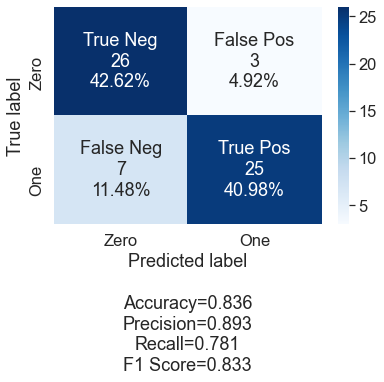

In [32]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### Tune XGBoost - Round 1

In [33]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3,4,5,6],
    'min_child_weight': [1, 2],
}

In [34]:

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1) #Using AUC to score
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 3
min_child_weight: 2


In [35]:
cf_matrix = confusion_matrix(y_test, test_preds)

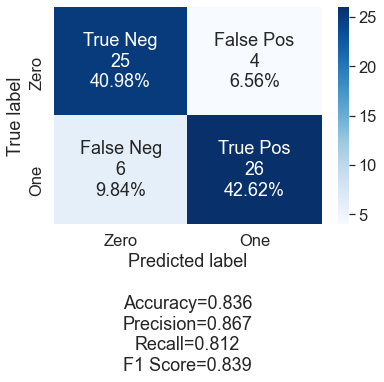

In [36]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### XGBoost Round 2

In [37]:
param_grid = {
    'learning_rate': [0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1],
    'subsample': [0.5, 0.6, 0.7,],
    'gamma': [0, 0.25, 0.5, .75, 1, 2, 3, 4, 5, 7, 10],
}

In [38]:

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1) #Using AUC to score
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)


Grid Search found the following optimal parameters: 
gamma: 0
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
subsample: 0.6


In [39]:
cf_matrix = confusion_matrix(y_test, test_preds)

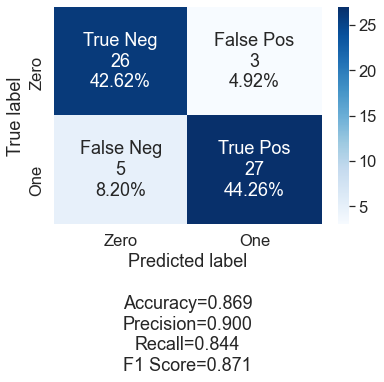

In [40]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

## XGBoost Round 3

In [41]:
param_grid = {
    'learning_rate': [0.2, 0.3],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1],
    'subsample': [0.5, 0.6, 0.7, 0.8],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.5, 0.75, 1]
}

In [42]:

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1) #Using AUC to score
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)


Grid Search found the following optimal parameters: 
colsample_bytree: 0.5
learning_rate: 0.2
max_depth: 4
min_child_weight: 1
n_estimators: 200
subsample: 0.8


In [43]:
cf_matrix = confusion_matrix(y_test, test_preds)

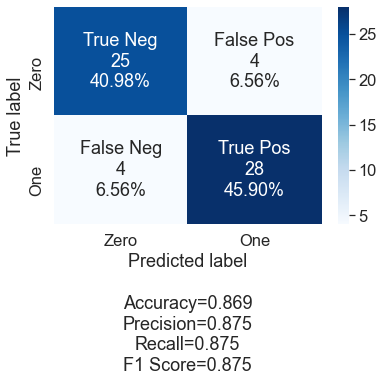

In [44]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

## XGBoost with Randomized Search

In [45]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000],
           'max_depth': [3, 4, 5, 6],
           }

classifier = xgboost.XGBClassifier()

rand_clf = RandomizedSearchCV(estimator=classifier,
                         param_distributions=params, n_iter=25,scoring='f1',n_jobs=-1,cv=5,verbose=3)
rand_clf.fit(X, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 125 | elapsed:   11.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   12.4s finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [46]:
training_preds = rand_clf.predict(X_train)
test_preds = rand_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

In [47]:
cf_matrix = confusion_matrix(y_test, test_preds)

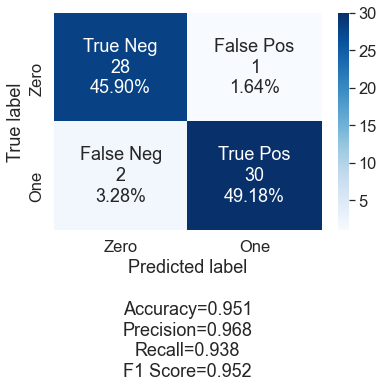

In [48]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

## Bagged Trees

In [49]:
# Instantiate BaggingClassifier
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [50]:
# Fit to the training data
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

In [51]:
# Train accuracy score
bagged_tree.score(X_train, y_train).round(2)

0.96

In [52]:
# Test accuracy score
bagged_tree.score(X_test, y_test).round(2)

0.85

## Random Forest

In [53]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [54]:
# Training accuracy score
forest.score(X_train, y_train).round(2)

0.93

In [55]:
# Test accuracy score
forest.score(X_test, y_test).round(2)

0.8

In [56]:
training_preds = forest.predict(X_train)
test_preds = forest.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

In [57]:
cf_matrix = confusion_matrix(y_test, test_preds)

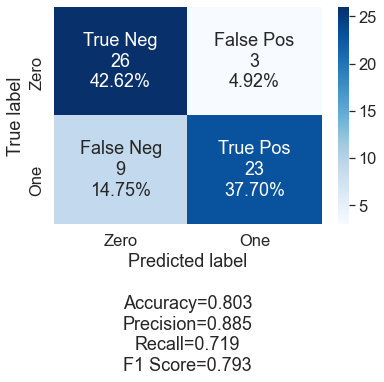

In [58]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [59]:
#define feature importance
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8, 20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

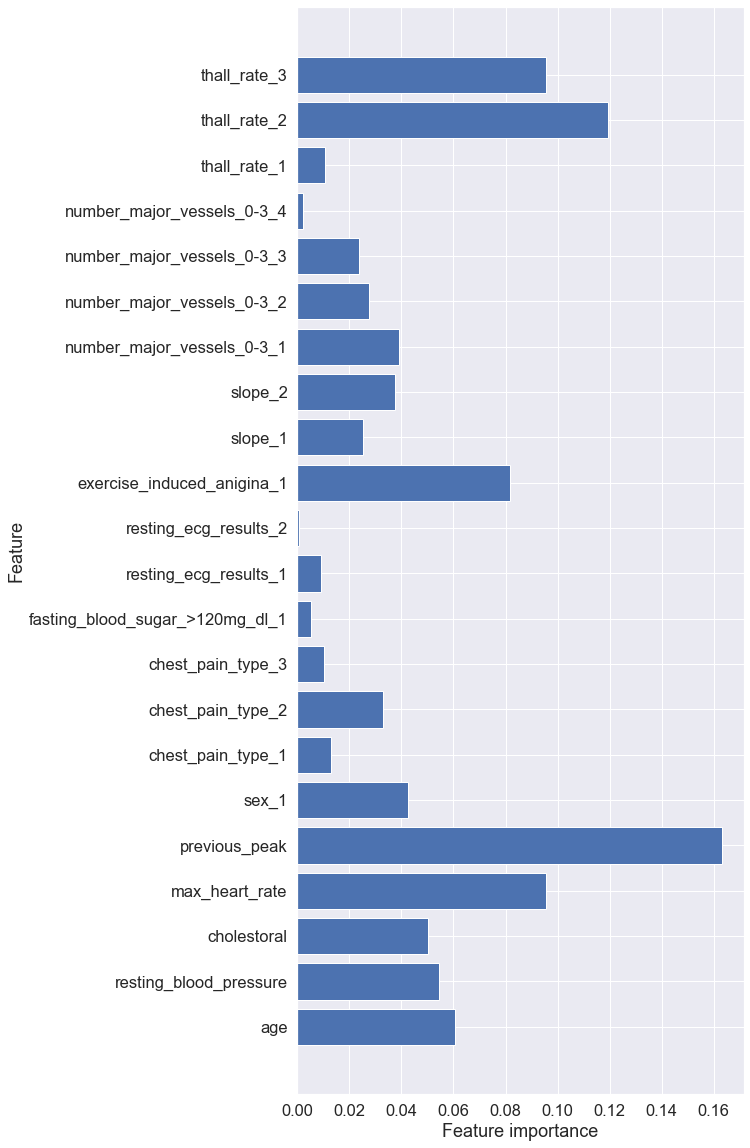

In [60]:
plot_feature_importances(forest)

## Final Model